# **Darts** - Time Series Forcasting **INForcast**

In [5]:
import pandas as pd
#from darts import TimeSeries
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os

directory_path = "../data/vaccine_"
file_list = os.listdir(directory_path)
file_list

['.DS_Store',
 'Influenza_Predictor_KMC.csv',
 'influenza_predictor2.csv',
 'influenza_predictor.csv',
 'influenzaSMW.csv']

In [4]:
data = pd.read_csv(f'../data/influenza_predictor2.csv')

In [3]:
practice_code = "E87750"

In [4]:
data.columns

Index(['Vaccination type', 'Event date', 'Patient ID', 'Date of birth',
       'Event done at ID', 'Patient Count'],
      dtype='object')

In [5]:

data.columns = ["vaccine", "date", "patient_id", "dob", "location", "patient_count"]
data.fillna(practice_code, inplace=True)
data.isna().sum()

vaccine          0
date             0
patient_id       0
dob              0
location         0
patient_count    0
dtype: int64

In [6]:
data.head()

,vaccine,date,patient_id,dob,location,patient_count
0,Influenza Vaccine 1,21-Oct-1993,19579730,08-Feb-2028,E87750,1
1,Influenza Vaccine 1,22-Nov-1996,19579289,13-May-1937,E87750,1
2,Influenza Vaccine 1,31-Oct-1997,17412404,30-Dec-1982,E87750,1
3,Influenza Vaccine 1,26-Nov-1997,17412911,27-Feb-1950,E87750,1
4,Influenza Vaccine 1,11-Dec-1997,59039995,06-Jun-1993,E87750,1


In [7]:
data['date'] = pd.to_datetime(data['date'], format="%d-%b-%Y")
data['dob'] = pd.to_datetime(data['dob'], format="%d-%b-%Y")

In [8]:
data = data[data['location'] == practice_code]

In [9]:
data['age_at_vaccine'] = data['date'].dt.year - data['dob'].dt.year
data = data[data['age_at_vaccine']> 0]

In [10]:
data.head()

,vaccine,date,patient_id,dob,location,patient_count,age_at_vaccine
1,Influenza Vaccine 1,1996-11-22,19579289,1937-05-13,E87750,1,59
2,Influenza Vaccine 1,1997-10-31,17412404,1982-12-30,E87750,1,15
3,Influenza Vaccine 1,1997-11-26,17412911,1950-02-27,E87750,1,47
4,Influenza Vaccine 1,1997-12-11,59039995,1993-06-06,E87750,1,4
5,Influenza Vaccine 1,1998-10-07,19579079,1938-02-03,E87750,1,60


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4891 entries, 1 to 6310
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   vaccine         4891 non-null   object        
 1   date            4891 non-null   datetime64[ns]
 2   patient_id      4891 non-null   int64         
 3   dob             4891 non-null   datetime64[ns]
 4   location        4891 non-null   object        
 5   patient_count   4891 non-null   int64         
 6   age_at_vaccine  4891 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(2), object(2)
memory usage: 286.6+ KB


In [12]:
children = data[data['age_at_vaccine'] <= 18]
over = data[data['age_at_vaccine'] >= 65]
under = data[(data['age_at_vaccine'] > 18) & (data['age_at_vaccine'] < 65)]

In [13]:
def to_timeseries(df, column, time_period="D"):
    # Resample and count occurrences in each period
    m_count = df.resample(time_period, on=column).size()

    # Convert to DataFrame
    m_count_df = m_count.reset_index()

    # Rename columns
    m_count_df.columns = ["date", "count"]

    return m_count_df

In [14]:
children_ts = to_timeseries(children, 'date', "M")
children_ts.set_index('date', inplace=True)

over_ts = to_timeseries(over, 'date', "M")
over_ts.set_index('date', inplace=True)

under_ts = to_timeseries(under, 'date', "M")
under_ts.set_index('date', inplace=True)

data_ts = to_timeseries(data, 'date', "M")

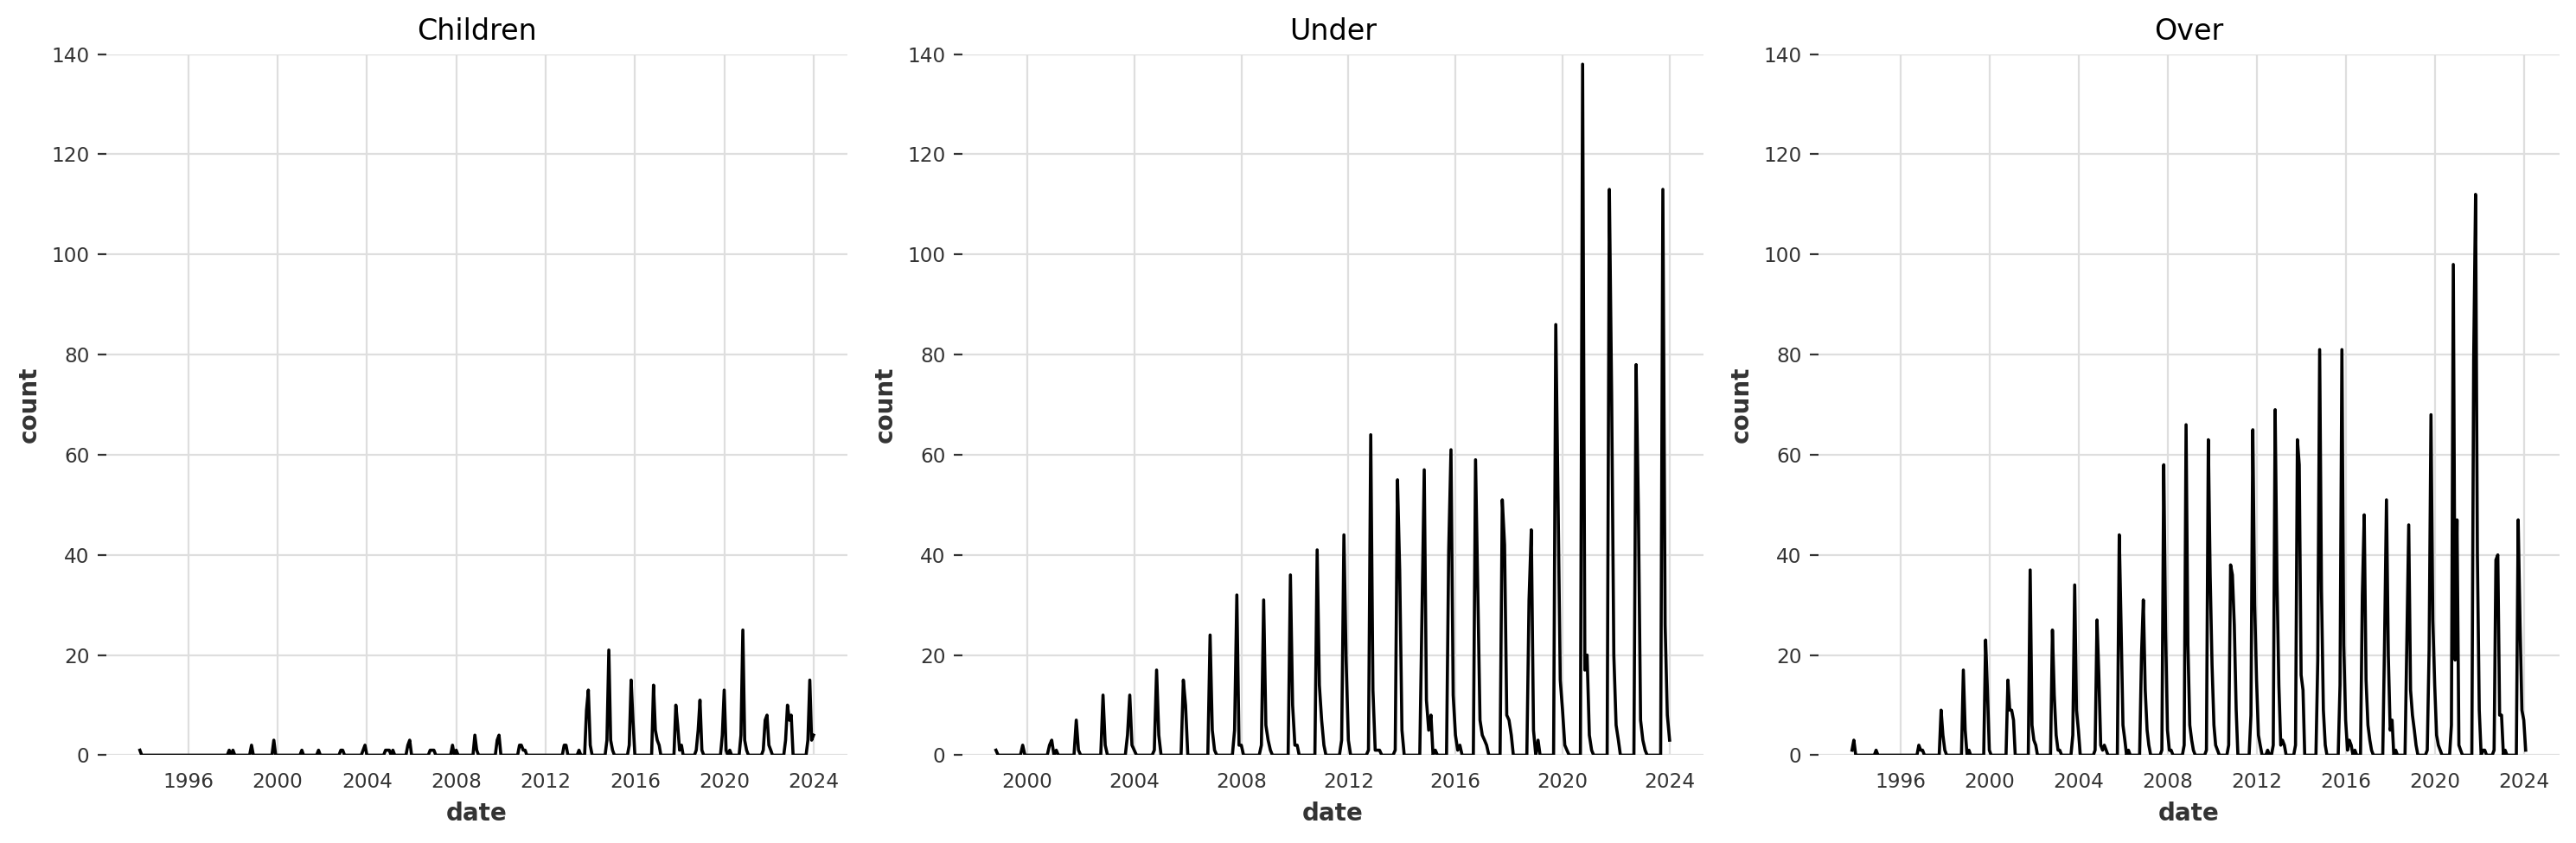

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each subplot and plot the data
for ax, data, title in zip(axes, [children_ts, over_ts, under_ts], ['Children', 'Under', 'Over']):
    sns.lineplot(data=data, x=data.index, y='count', ax=ax)
    ax.set_title(title)
    
    # Set y-axis limits to 0 and 140
    ax.set_ylim(0, 140)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [16]:
children_ts['count'].sum()

314

In [17]:
under_ts['count'].sum()

2624

In [18]:
over_ts['count'].sum()

1953

In [19]:
data_ts.head()

,date,count
0,1993-10-31,2
1,1993-11-30,3
2,1993-12-31,0
3,1994-01-31,0
4,1994-02-28,0


In [20]:
data_ts['count']= data_ts['count'] + 0.01

In [21]:
data_ts

,date,count
0,1993-10-31,2.01
1,1993-11-30,3.01
2,1993-12-31,0.01
3,1994-01-31,0.01
4,1994-02-28,0.01
...,...,...
359,2023-09-30,163.01
360,2023-10-31,67.01
361,2023-11-30,20.01
362,2023-12-31,14.01


In [22]:
data_ts['count'].astype('float32')

0        2.010000
1        3.010000
2        0.010000
3        0.010000
4        0.010000
          ...    
359    163.009995
360     67.010002
361     20.010000
362     14.010000
363      1.010000
Name: count, Length: 364, dtype: float32

In [23]:
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [24]:
series =  TimeSeries.from_dataframe(data_ts, time_col='date', value_cols='count')

<Axes: xlabel='date'>

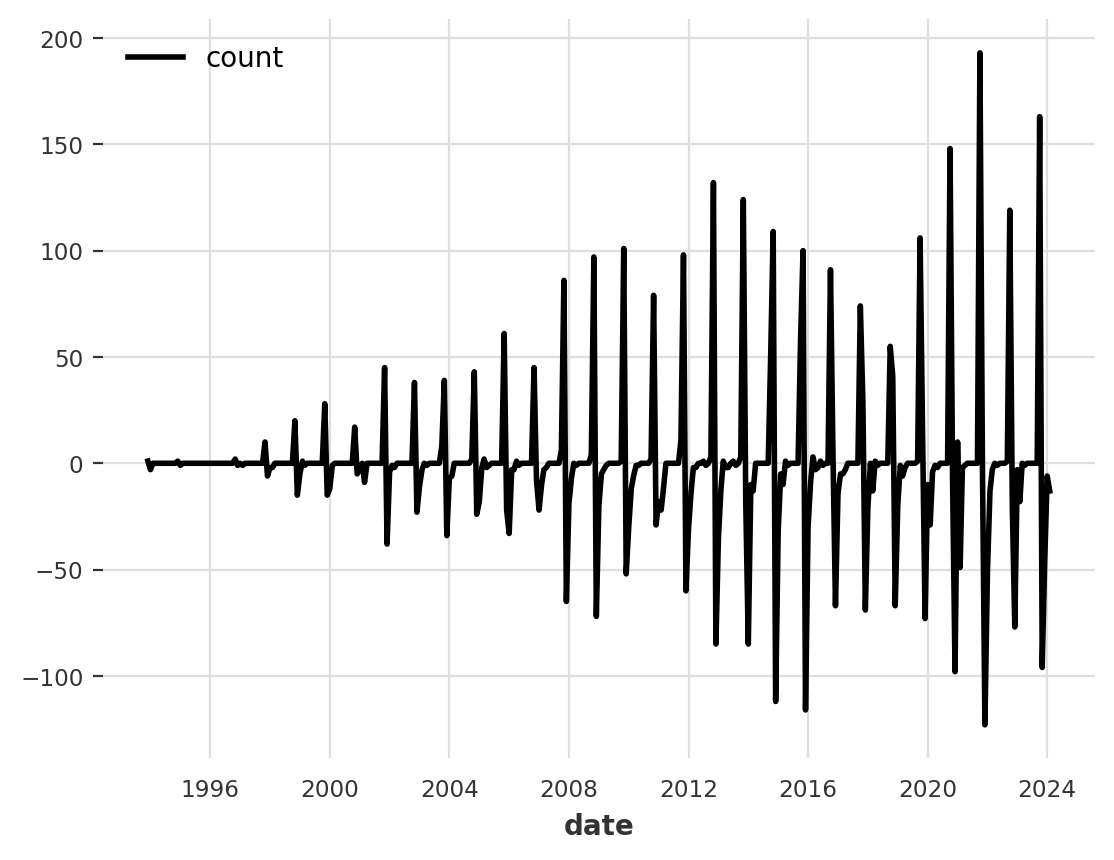

In [25]:
series.diff().plot()

<Axes: xlabel='date'>

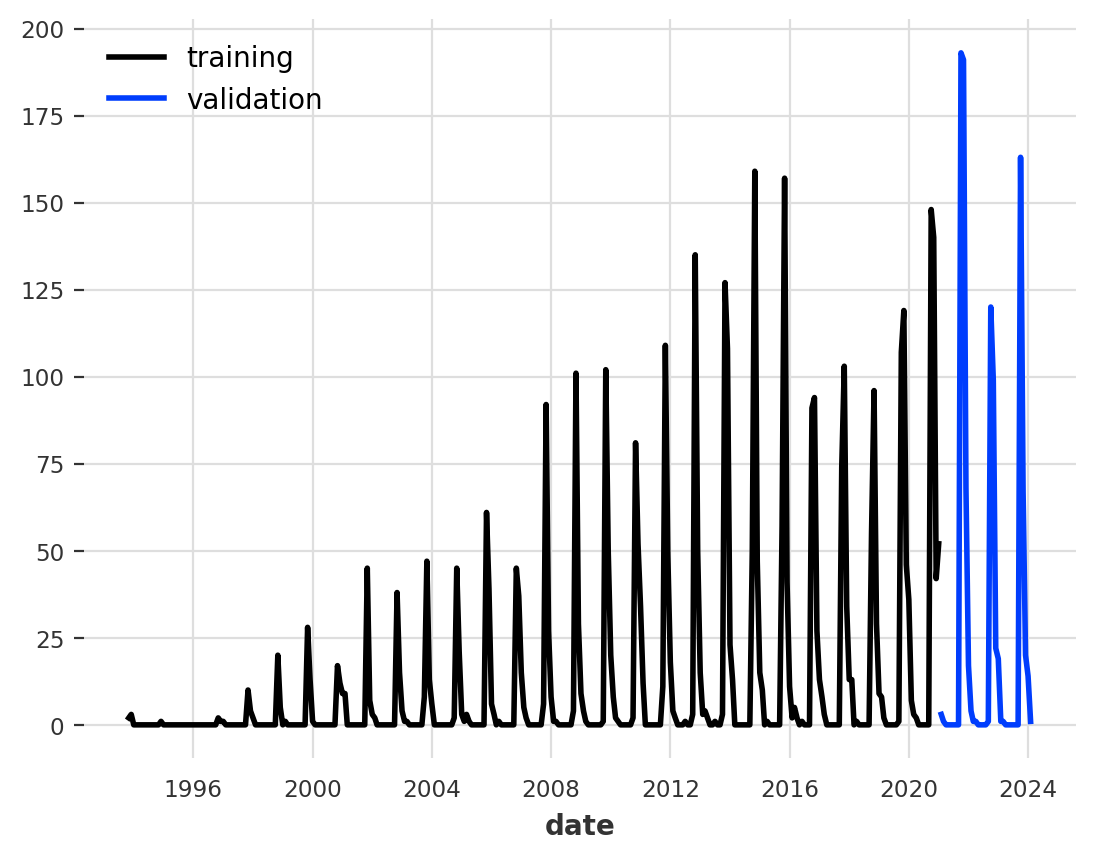

In [26]:
train, val = series.split_after(0.90)
train.plot(label="training")
val.plot(label="validation")

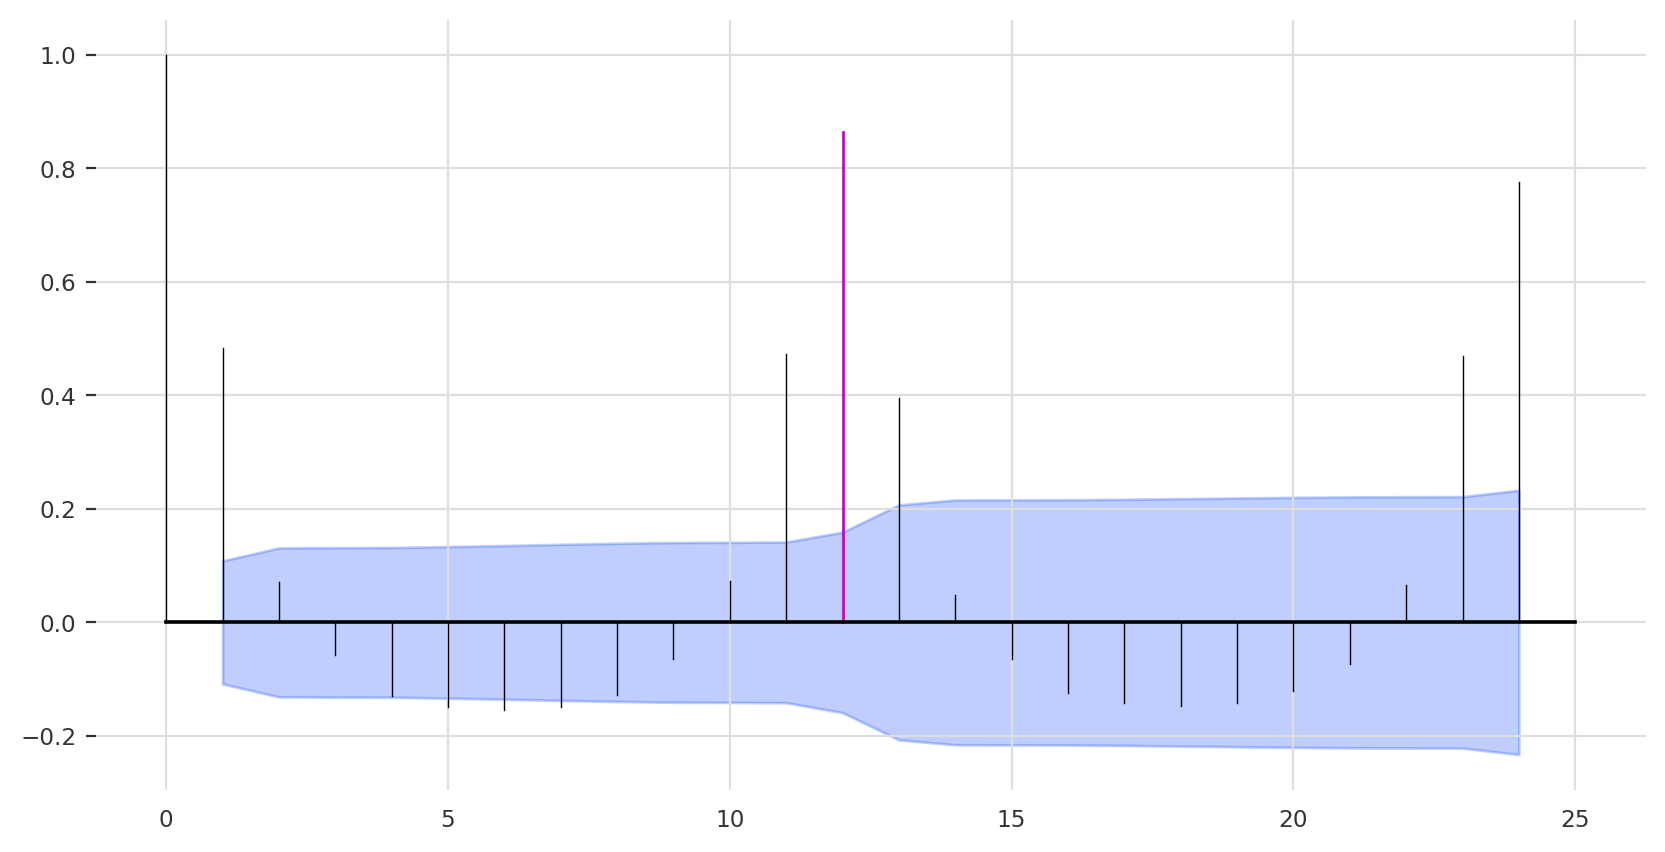

In [27]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [28]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


<Axes: xlabel='date'>

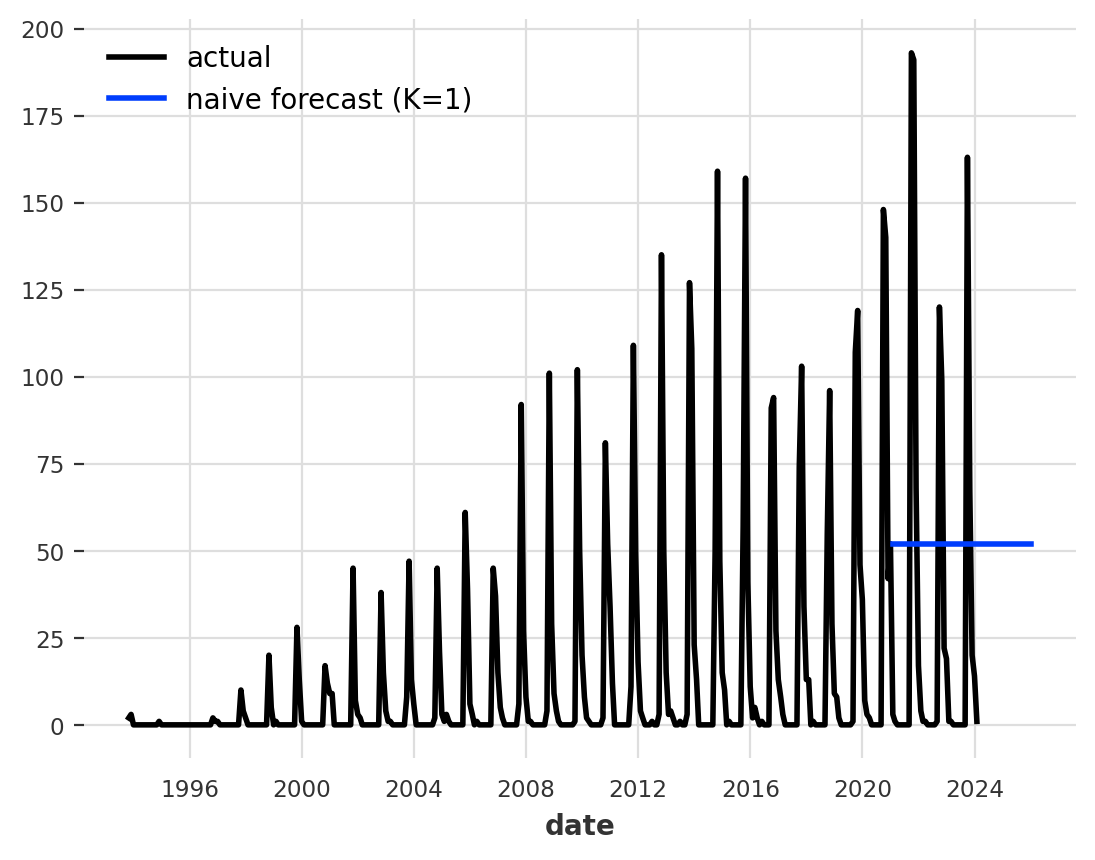

In [29]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(60)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

<Axes: xlabel='date'>

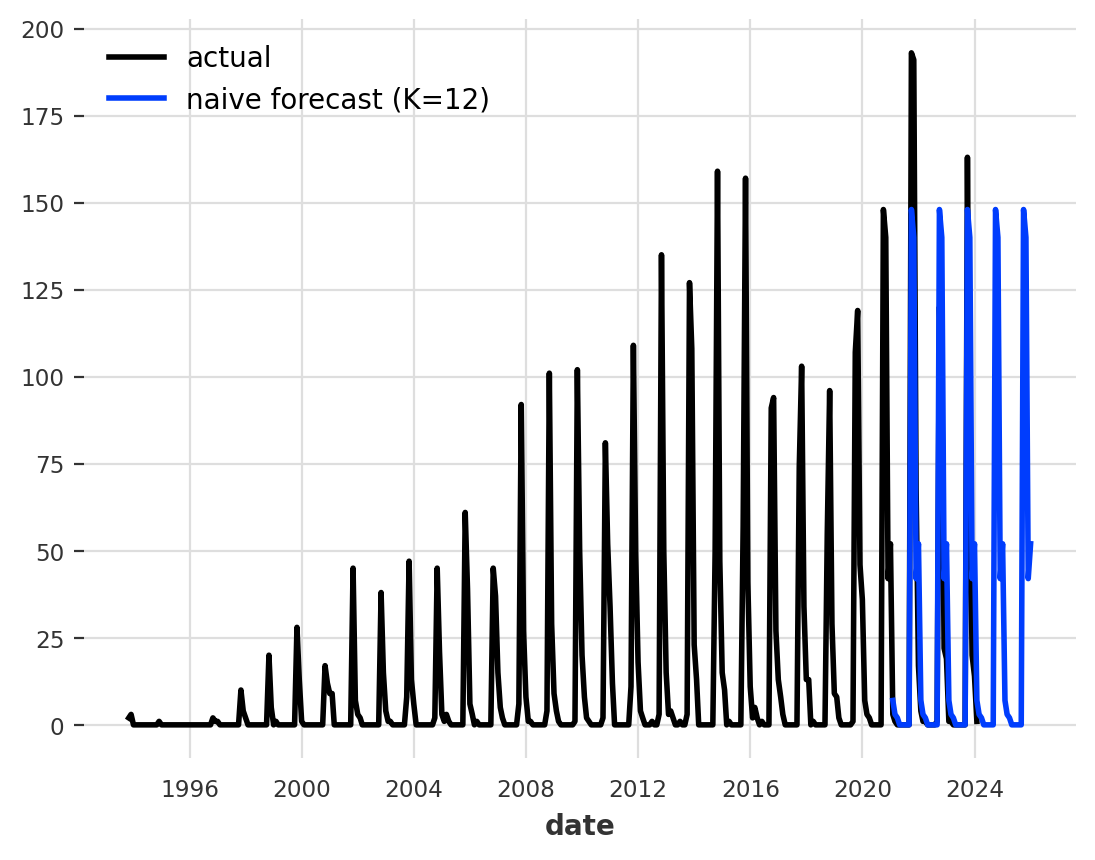

In [30]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(60)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

<Axes: xlabel='date'>

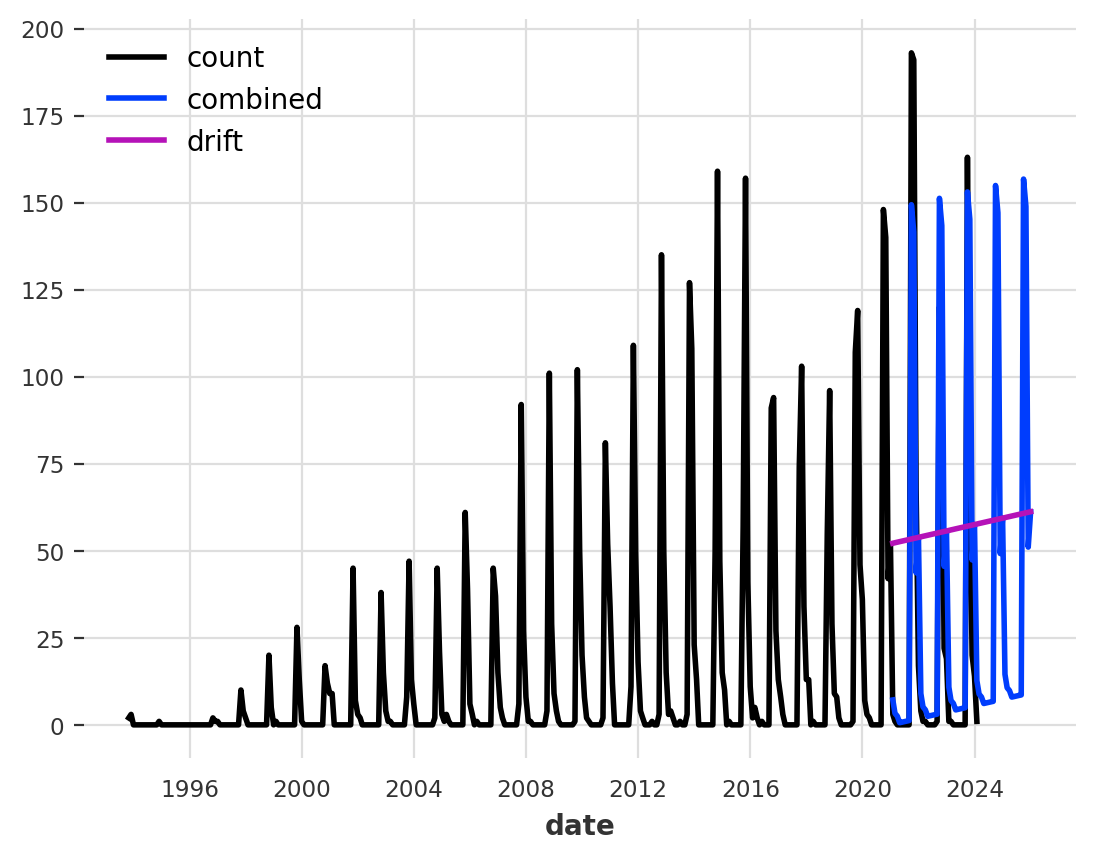

In [31]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(60)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [32]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 12833.65%.


In [33]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 19776.65%
model TBATS() obtains MAPE: 377.72%
model AutoARIMA() obtains MAPE: 175001.01%
model Theta() obtains MAPE: 3409.52%


In [34]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

NameError: name 'best_theta_model' is not defined

  0%|          | 0/208 [00:00<?, ?it/s]

MAPE = 83.24%


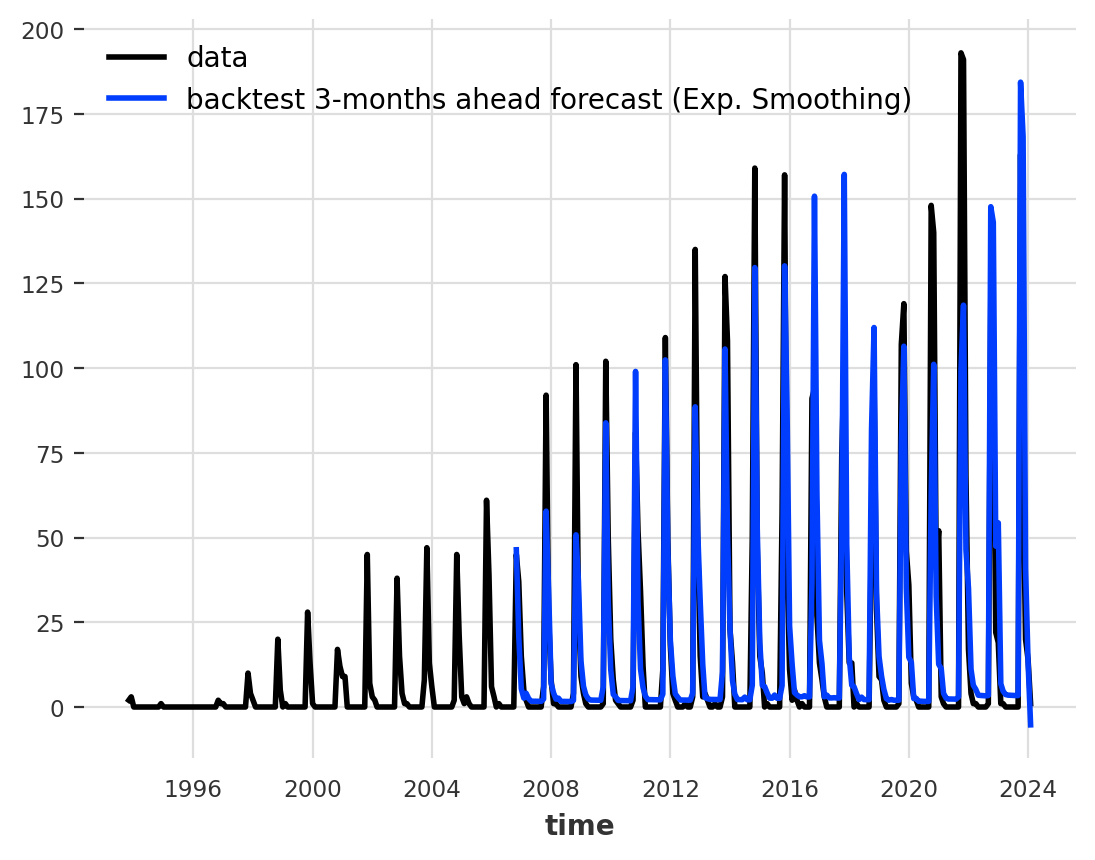

In [35]:
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.4, forecast_horizon=12, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

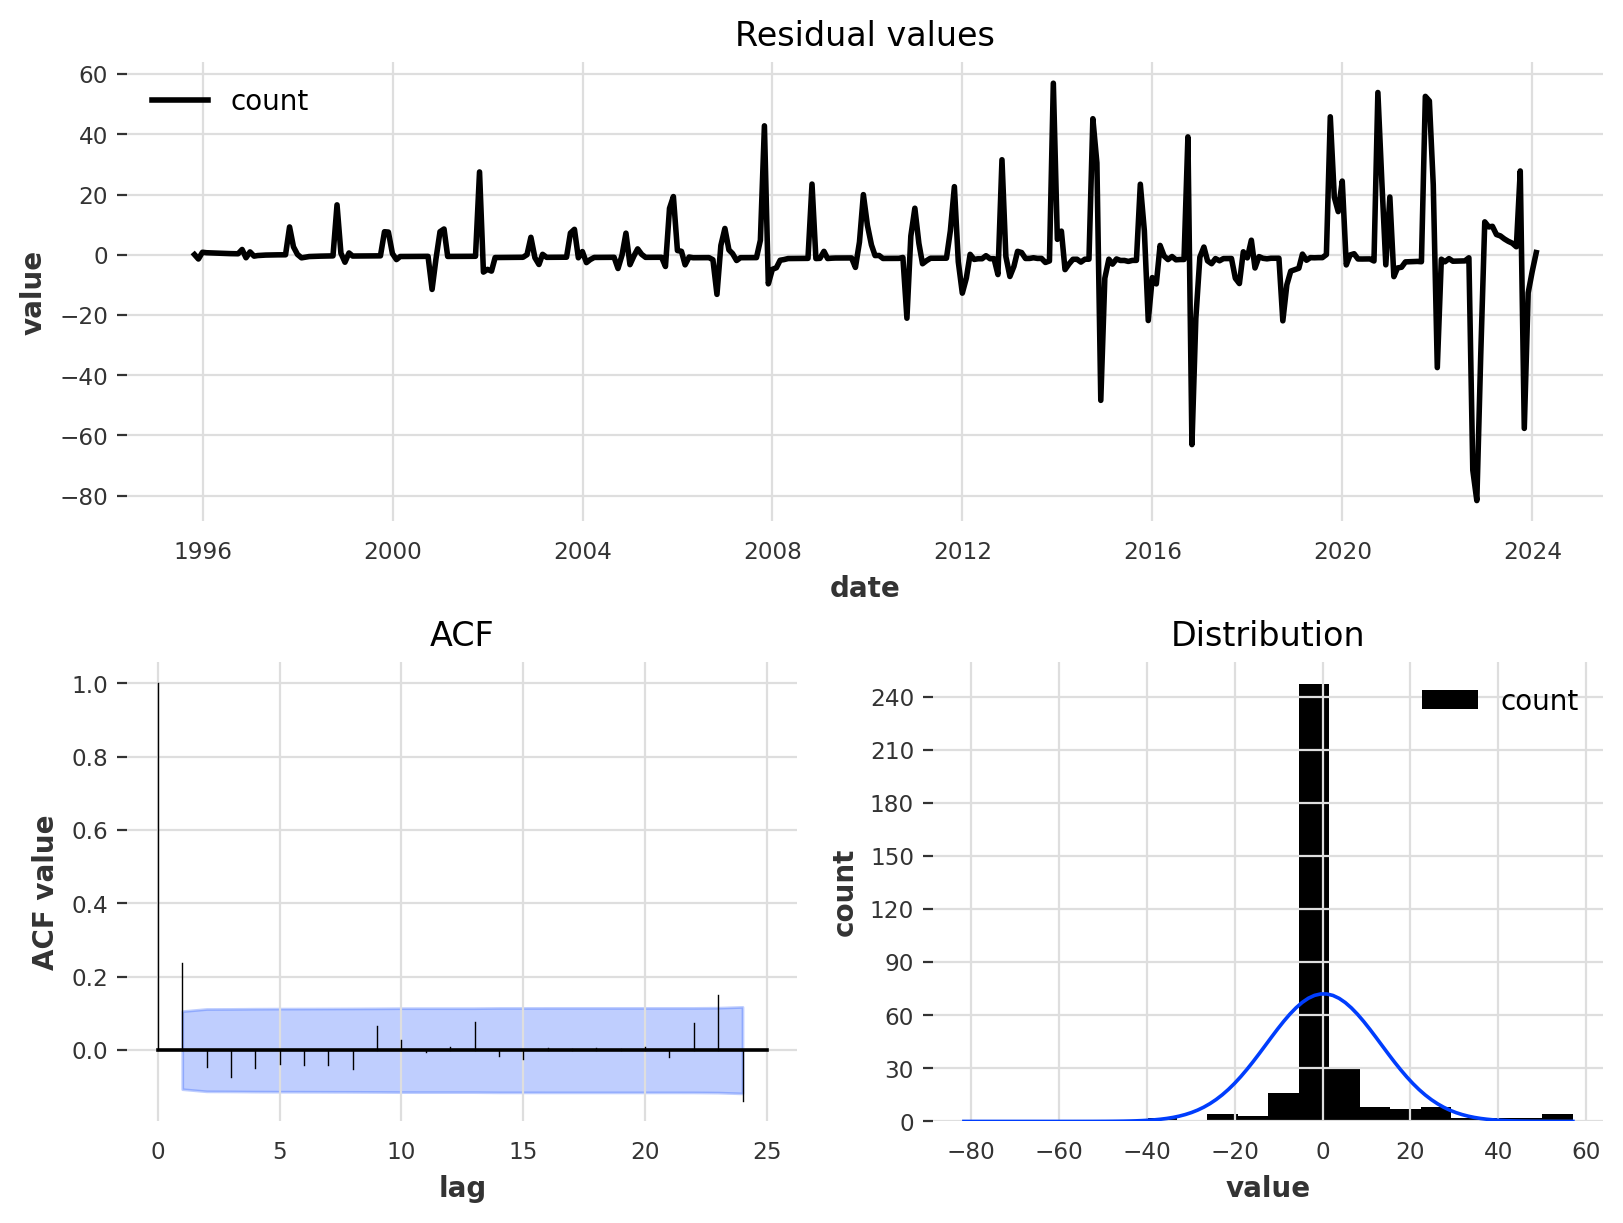

In [36]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(model_es.residuals(series))

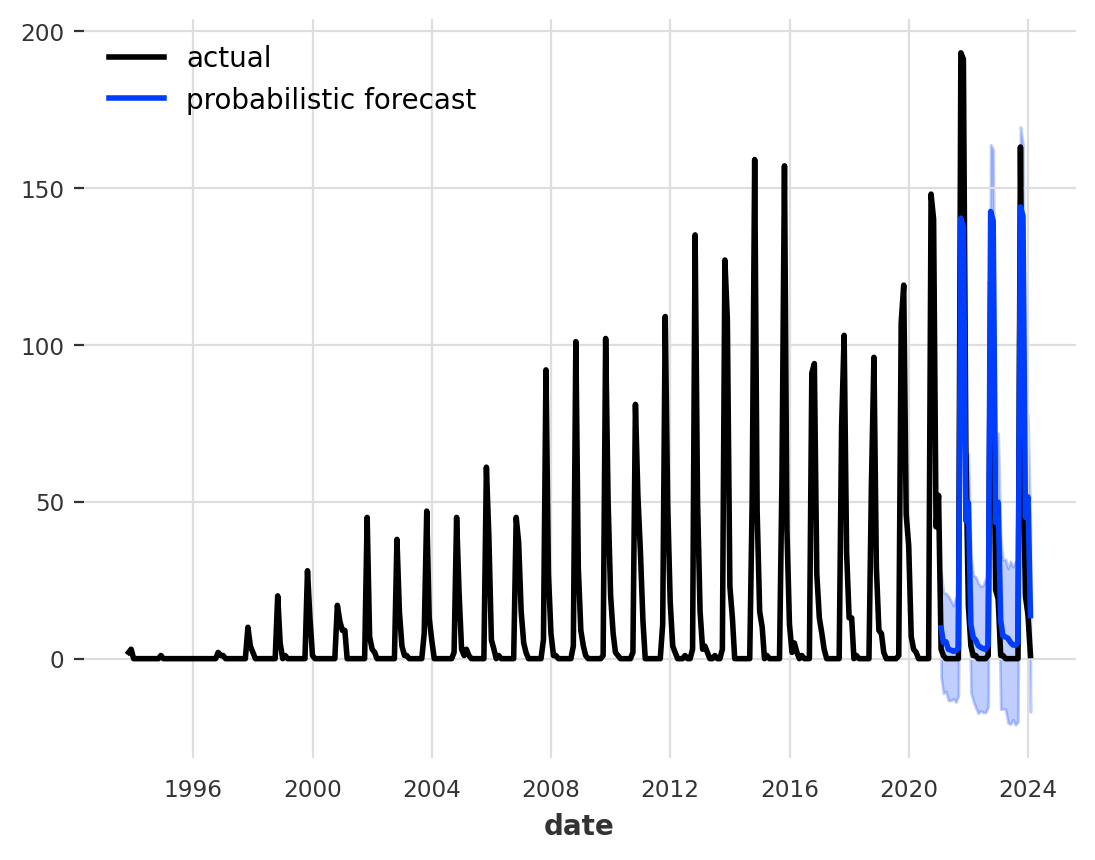

In [37]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [38]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 19776.65%
model TBATS() obtains MAPE: 377.72%
model AutoARIMA() obtains MAPE: 175001.01%
model Theta() obtains MAPE: 3409.52%


In [39]:
import numpy as np
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [40]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 1018.91, with theta = 0.16326530612244916.


<Axes: xlabel='date'>

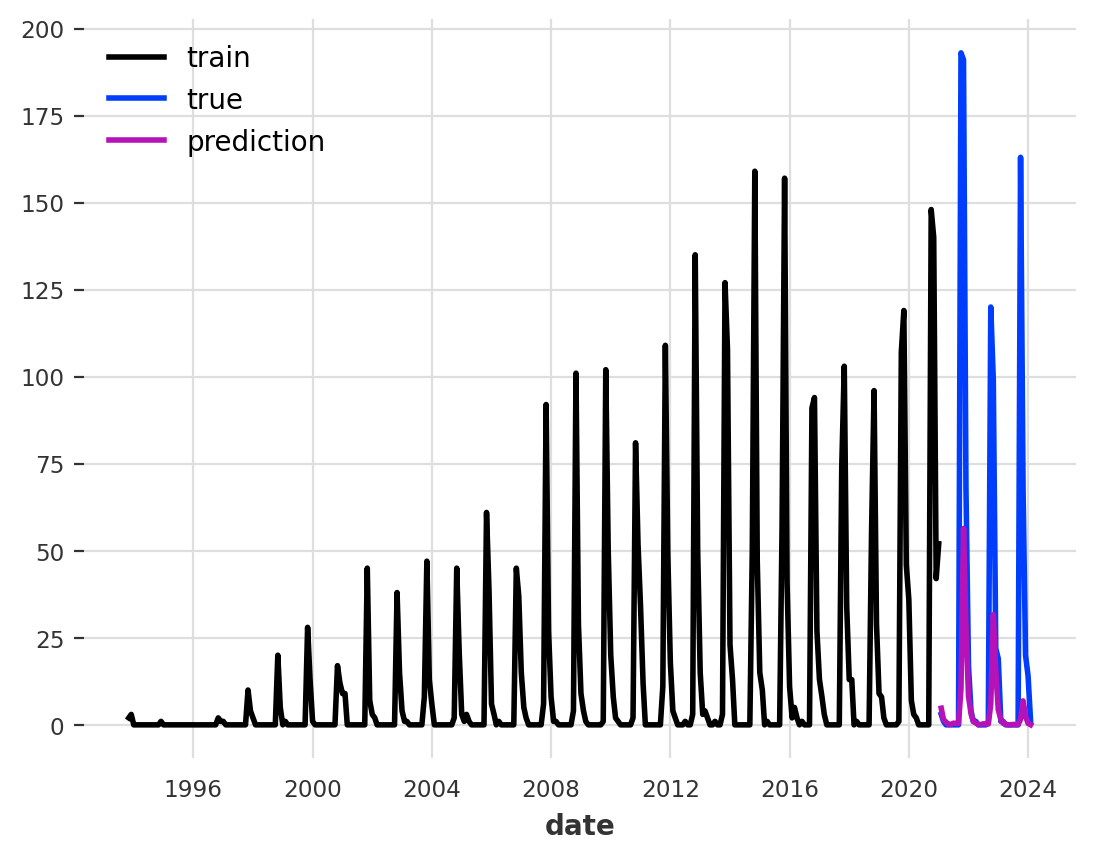

In [41]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

  0%|          | 0/145 [00:00<?, ?it/s]

MAPE = 305.99%


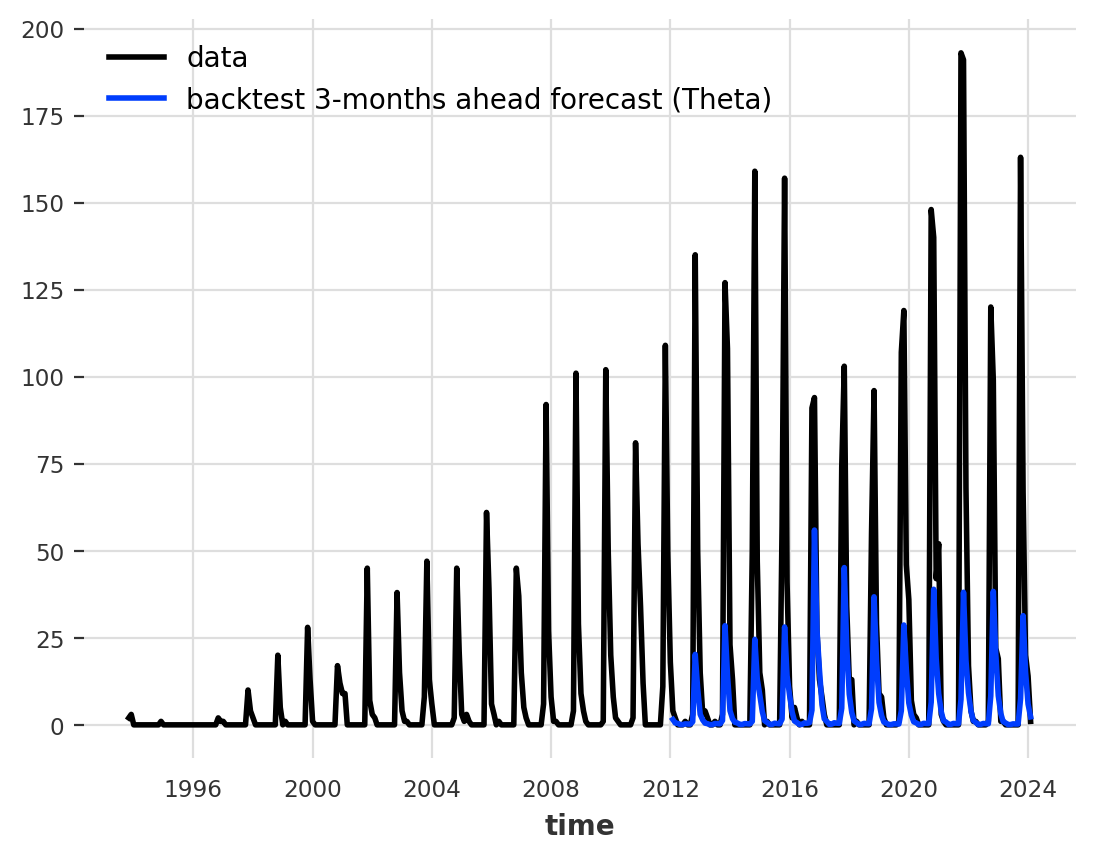

In [42]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/145 [00:00<?, ?it/s]

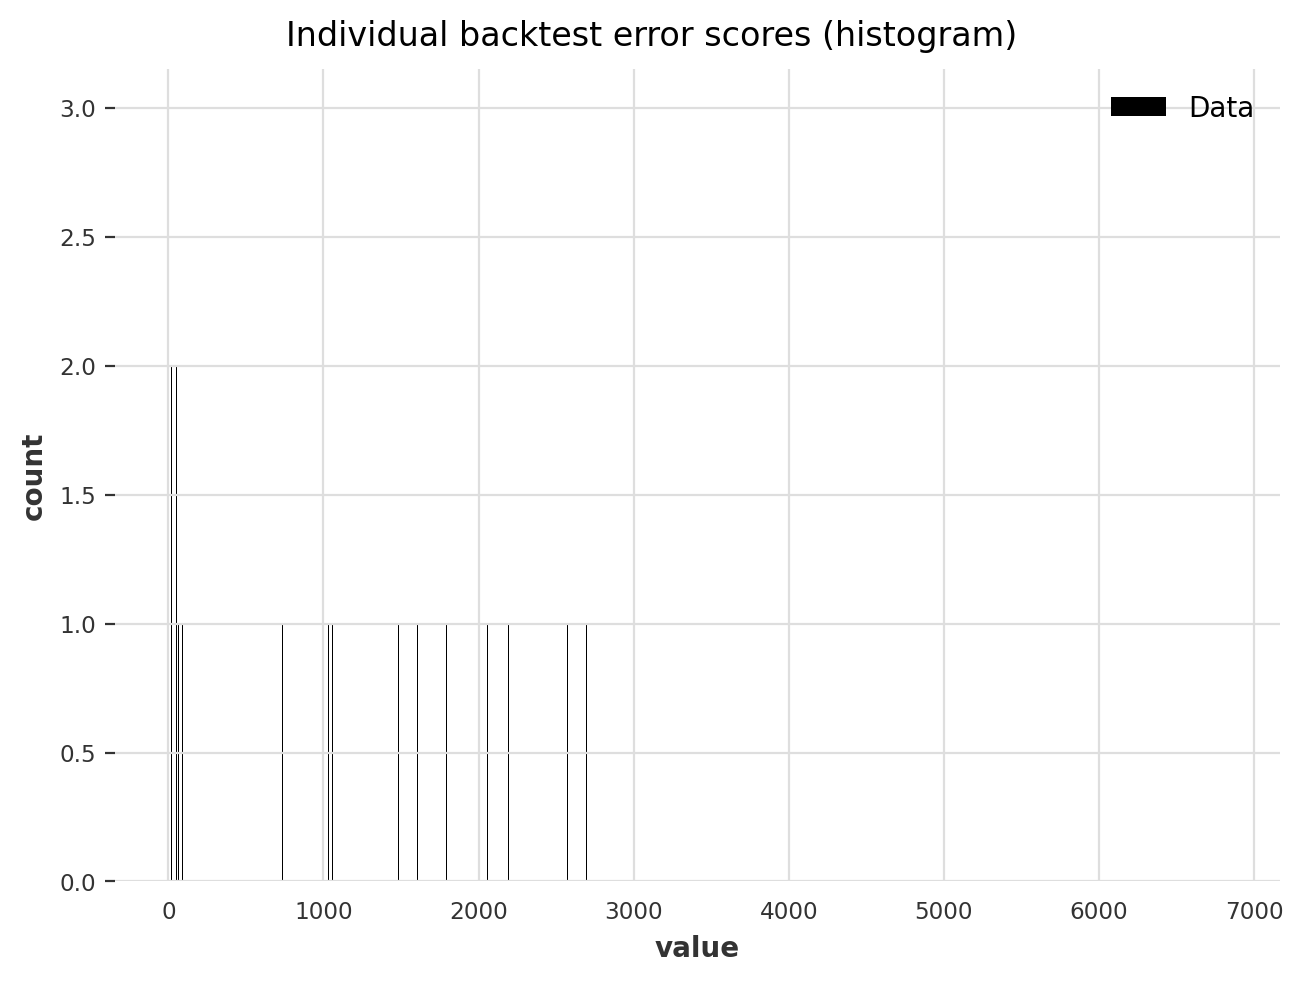

In [43]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [44]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

NameError: name 'train_air_scaled' is not defined

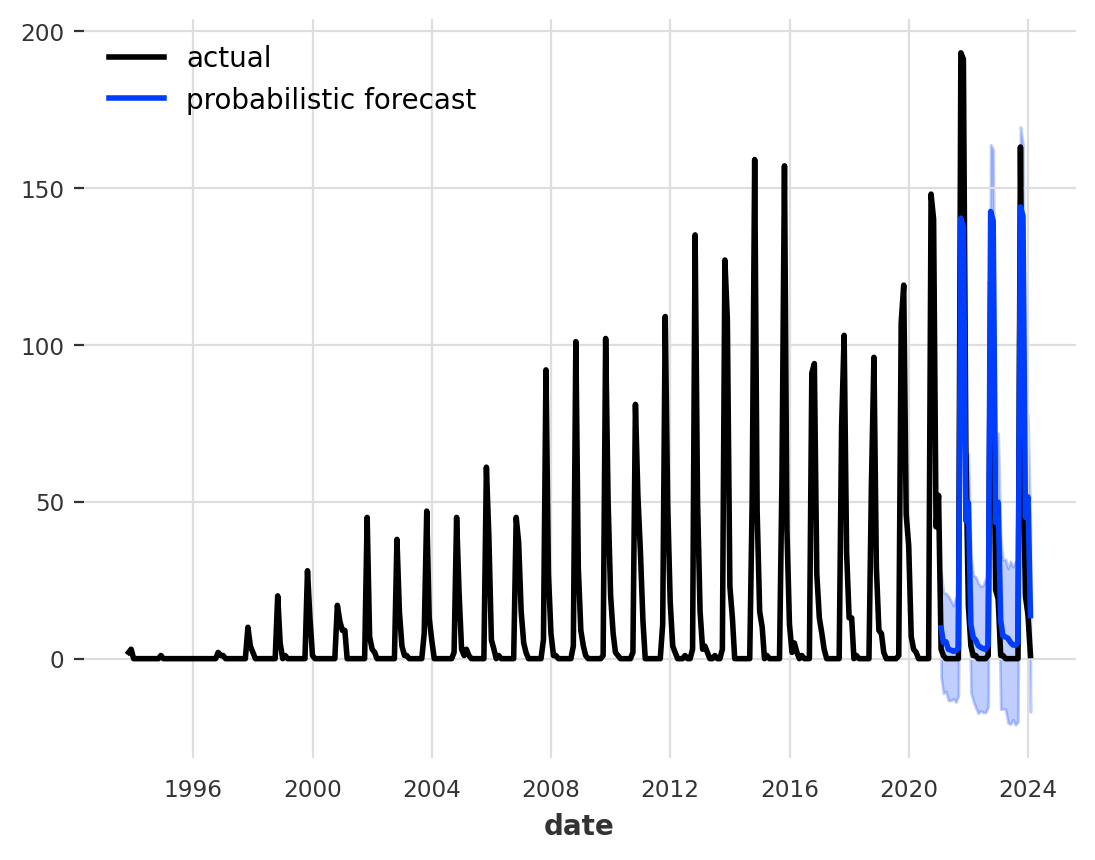

In [45]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [46]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train, epochs=400, verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
over_ts.reset_index(inplace=True)

In [47]:
over_ts

,count
date,
1998-10-31,1
1998-11-30,0
1998-12-31,0
1999-01-31,0
1999-02-28,0
...,...
2023-08-31,0
2023-09-30,113
2023-10-31,26


In [48]:
over_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 303 entries, 1998-10-31 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   303 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


In [49]:
series =  TimeSeries.from_dataframe(over_ts, time_col='date', value_cols='count')

AttributeError: time_col='date' is not present.


AttributeError: time_col='date' is not present.

<Axes: xlabel='date'>

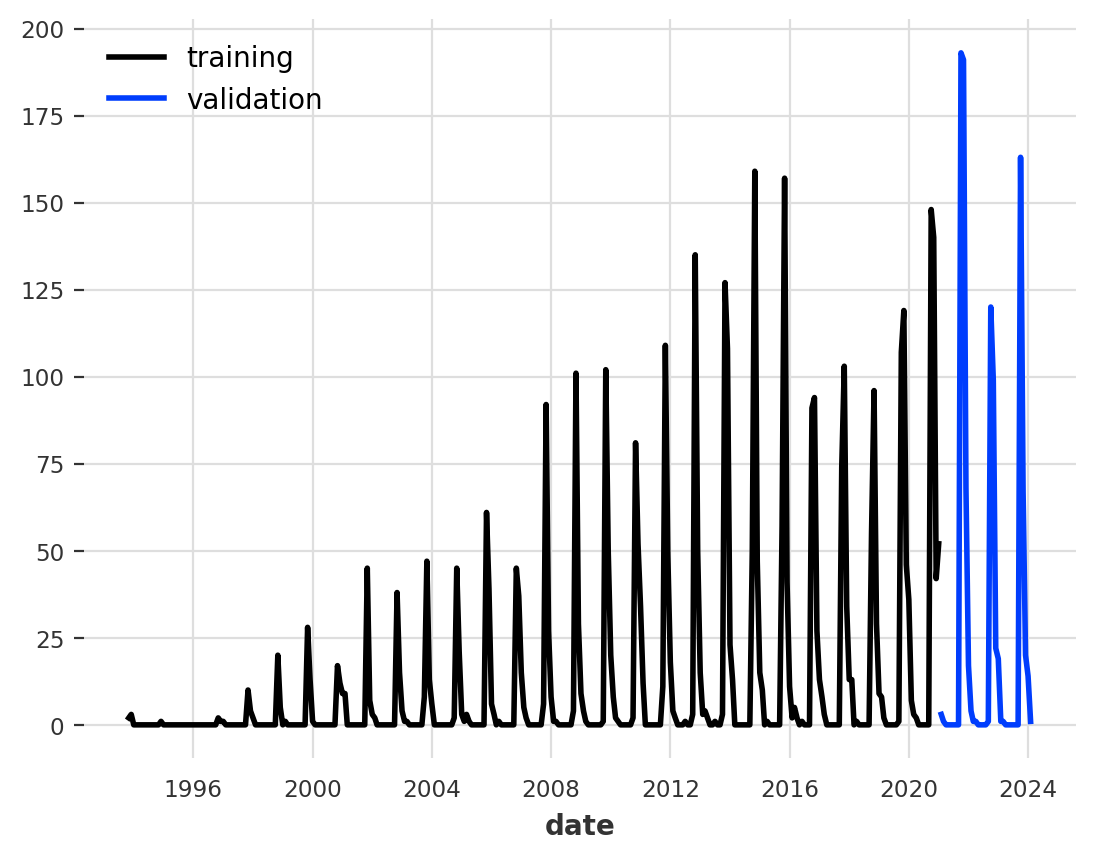

In [50]:
train, val = series.split_after(0.90)
train.plot(label="training")
val.plot(label="validation")

In [51]:
from darts import TimeSeries
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Assuming 'series' is your TimeSeries object.

# Create the Prophet model
model = Prophet()

# Fit the model to your series
model.fit(series)

# Define the length of the forecast horizon
# For example, to predict the next 24 months:
forecast_horizon = 24
series = series.resample('MS')
# Create a future time series (if your series has a DateTime index)
future_times = series.time_index[-1] + series.freq * np.arange(1, forecast_horizon + 1)
future_series = datetime_attribute_timeseries(future_times, attribute='day', one_hot=False)

# Predict the future
forecast = model.predict(future_series)

07:38:57 - cmdstanpy - INFO - Chain [1] start processing
07:38:57 - cmdstanpy - INFO - Chain [1] done processing
ValueError: `time_index` must be a pandas `DatetimeIndex` or a `TimeSeries` indexed with a `DatetimeIndex`.


ValueError: `time_index` must be a pandas `DatetimeIndex` or a `TimeSeries` indexed with a `DatetimeIndex`.

# Prediction using **ExponentialSmoothing**

In [52]:
data = pd.read_csv('../data/influenza_predictor.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/influenza_predictor.csv'

In [53]:
data.head()

,count
date,
1993-10-31,1
1993-11-30,3
1993-12-31,0
1994-01-31,0
1994-02-28,0


In [54]:
practice_code = "E87750"

In [55]:
# Let's aggregate the data by month and count the number of vaccination events
data = data[data['Event done at ID'] == practice_code]
# Converting 'Event date' to datetime format
data['Event date'] = pd.to_datetime(data['Event date'], format='%d-%b-%Y')
data['Date of birth'] = pd.to_datetime(data['Date of birth'], format='%d-%b-%Y')
data['age_at_vaccine'] = data['Event date'].dt.year - data['Date of birth'].dt.year
data = data[data['age_at_vaccine']> 18]
# Aggregating data by month
monthly_data = data.groupby(pd.Grouper(key='Event date', freq='M')).size()

# Resetting the index to have 'Event date' as a column
monthly_data = monthly_data.reset_index()

# Renaming columns for clarity
monthly_data.columns = ['Month', 'Vaccination Count']

# Showing the first few rows of the aggregated monthly data
monthly_data.head()

KeyError: 'Event done at ID'

In [56]:
from darts import TimeSeries

# Convert the aggregated data to a TimeSeries object
ts = TimeSeries.from_dataframe(monthly_data, 'Month', 'Vaccination Count')

NameError: name 'monthly_data' is not defined

In [57]:
# Split the data (for example, using the last 12 months for validation)
train, val = ts.split_before(pd.Timestamp('2023-01-31'))

NameError: name 'ts' is not defined

In [58]:
from darts.models import ExponentialSmoothing

# Create the Exponential Smoothing model
model = ExponentialSmoothing()

# Train the model on the training set
model.fit(train)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0, kwargs=None)

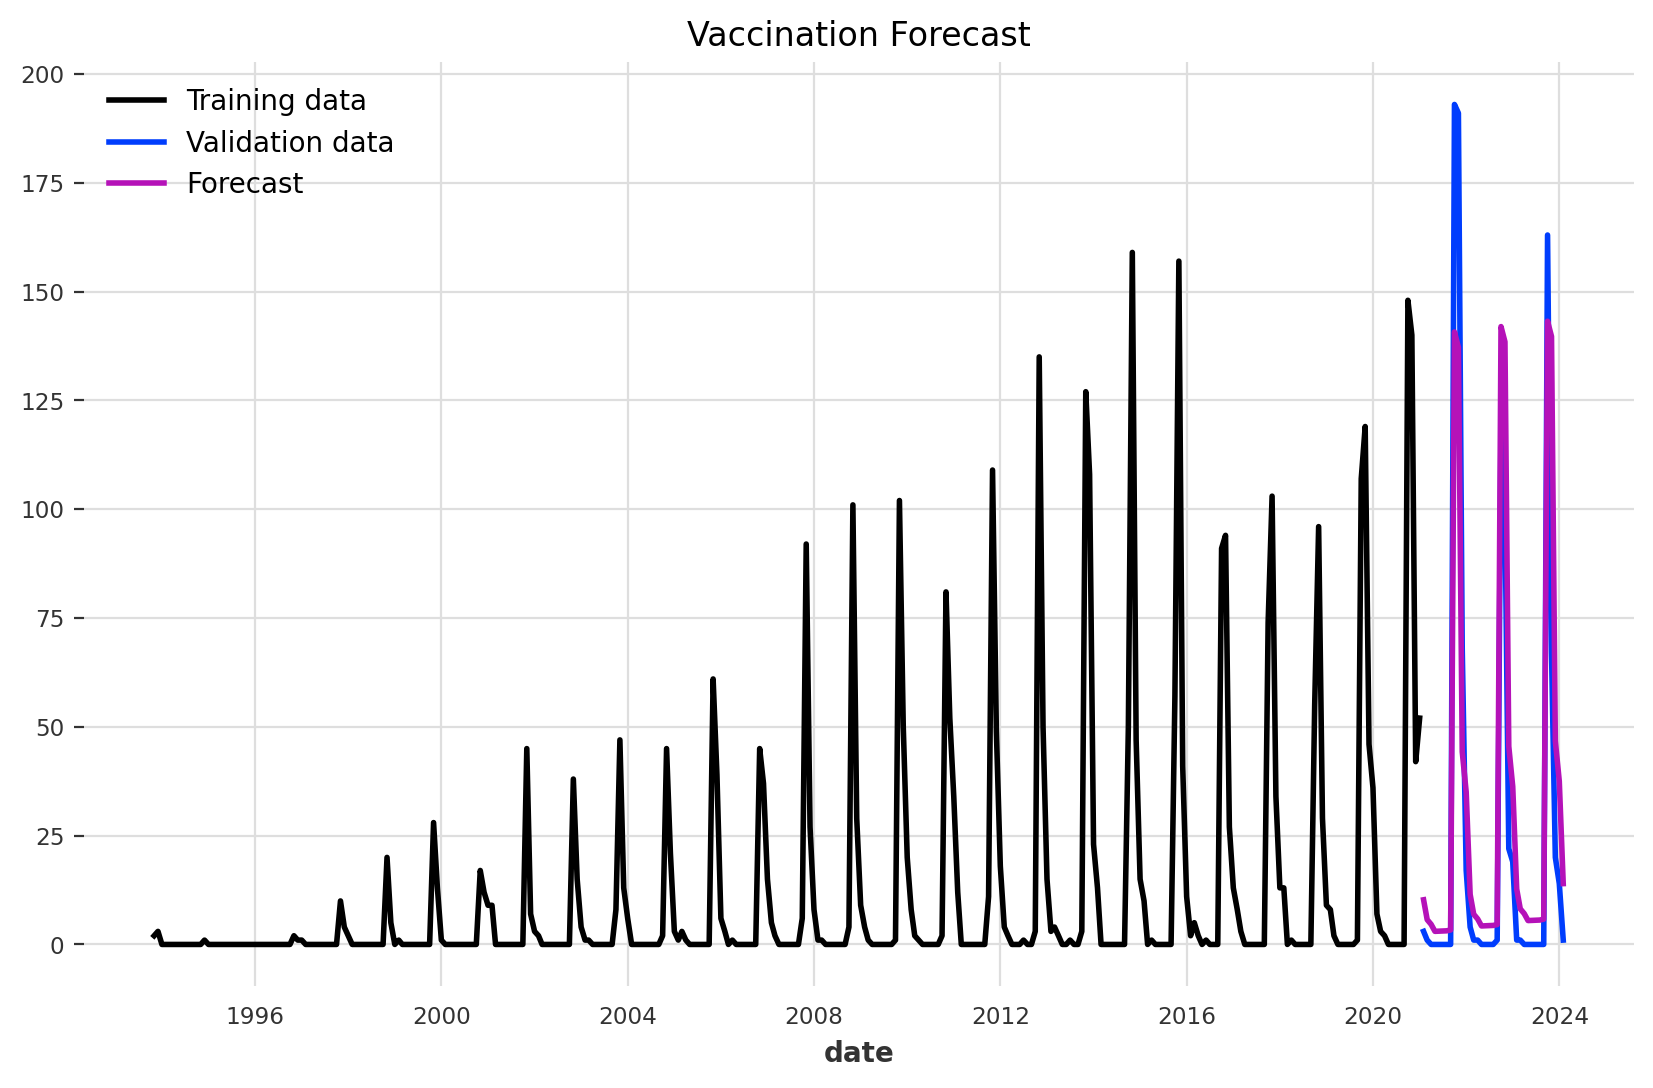

In [59]:
prediction = model.predict(len(val))

# Compare predictions with the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
train.plot(label='Training data')
val.plot(label='Validation data')
prediction.plot(label='Forecast')
plt.title('Vaccination Forecast')
plt.legend()

In [60]:
from darts.metrics import mape, mae, rmse

# Calculate Mean Absolute Percentage Error (MAPE)
#mape_score = mape(val, prediction)

# Calculate Mean Absolute Error (MAE)
mae_score = mae(val, prediction)

# Calculate Root Mean Squared Error (RMSE)
rmse_score = rmse(val, prediction)

(mae_score, rmse_score)


(14.351384118529962, 21.597634044015788)

In [61]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape, mae, rmse

def eval_model(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAE: {:.2f}".format(model, mae(val, forecast)))
    print("model {} obtains RMSE: {:.2f}".format(model, rmse(val, forecast)))

# Assuming 'train' and 'val' are defined TimeSeries objects for your training and validation datasets
eval_model(ExponentialSmoothing(), train, val)
eval_model(TBATS(), train, val)
eval_model(AutoARIMA(), train, val)
eval_model(Theta(), train, val)

model ExponentialSmoothing() obtains MAE: 14.35
model ExponentialSmoothing() obtains RMSE: 21.60
model TBATS() obtains MAE: 19.08
model TBATS() obtains RMSE: 48.91
model AutoARIMA() obtains MAE: 44.89
model AutoARIMA() obtains RMSE: 54.39
model Theta() obtains MAE: 19.64
model Theta() obtains RMSE: 44.16


In [62]:
import pandas as pd

# Assuming your last date in the dataset is in the format YYYY-MM-DD
last_date_in_dataset = pd.to_datetime(monthly_data['Month'].iloc[-1])

# Target end date (end of January 2025)
end_date = pd.Timestamp('2025-01-31')

# Calculate the number of months to forecast
months_to_forecast = (end_date.year - last_date_in_dataset.year) * 12 + end_date.month - last_date_in_dataset.month


NameError: name 'monthly_data' is not defined

In [ ]:
months_to_forecast

In [ ]:
# Forecast the future values
future_forecast = model.predict(13)


In [ ]:
future_forecast

In [ ]:
# Plotting the forecast along with the historical data
plt.figure(figsize=(10, 6))
ts.plot(label='Historical Data')
future_forecast.plot(label='Forecast until Jan 2025')
plt.title('Vaccination Forecast until Jan 2025')
plt.legend()
plt.show()


In [ ]:
# Convert the TimeSeries forecast to a pandas Series
forecast_series = future_forecast.pd_series()

# Sum the forecasted values to get the total number of predicted vaccinations
total_vaccinations_predicted = forecast_series.sum()

print(f"Total number of predicted vaccinations until Jan 2025: {total_vaccinations_predicted}")


In [ ]:
import itertools
from darts.models import ExponentialSmoothing
from darts.metrics import mae  # or any other suitable metric

# Example hyperparameter ranges (adjust based on your needs)
smoothing_level_options = [0.1, 0.5, 0.9]
smoothing_trend_options = [0.1, 0.5, 0.9]
smoothing_seasonal_options = [0.1, 0.5, 0.9]
damped_trend_options = [True, False]

# Create a grid of all hyperparameter combinations
param_grid = itertools.product(
    smoothing_level_options, 
    smoothing_trend_options, 
    smoothing_seasonal_options, 
    damped_trend_options
)

best_score = float('inf')
best_params = None

for params in param_grid:
    model = ExponentialSmoothing(
        smoothing_level=params[0], 
        smoothing_trend=params[1], 
        smoothing_seasonal=params[2], 
        damped_trend=params[3]
    )

    model.fit(train_series)
    forecast = model.predict(len(val_series))
    score = mae(val_series, forecast)

    if score < best_score:
        best_score = score
        best_params = params

print(f"Best Parameters: {best_params}, MAE: {best_score}")
